# 03 - Model Evaluation

This notebook:
- Loads forecast results from all models
- Calculates point forecast metrics (MAPE, sMAPE, MASE)
- Calculates probabilistic metrics (CRPS, coverage)
- Runs Diebold-Mariano tests for statistical significance
- Generates summary tables and visualizations

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from scipy import stats

np.random.seed(42)

## Load Data

In [2]:
project_root = Path.cwd().parent
data_dir = project_root / 'data'
results_dir = project_root / 'results'
forecasts_dir = results_dir / 'forecasts'
figures_dir = results_dir / 'figures'

figures_dir.mkdir(parents=True, exist_ok=True)

In [3]:
# Load actual data
flu_series = pd.read_pickle(data_dir / 'flu_daily_clean.pkl')
print(f"Actual data: {len(flu_series)} observations from {flu_series.index.min()} to {flu_series.index.max()}")

Actual data: 1078 observations from 2022-07-04 00:00:00 to 2025-06-15 00:00:00


In [4]:
# Load ALL models: foundation models, baselines, and optimized versions
# We compare all 7 models:
# - Foundation: Chronos_Tiny, TabPFN_TS (baseline univariate), TabPFN_Enhanced (with features)
# - Baselines: SARIMA_Baseline (fixed order), LightGBM_Baseline (defaults)
# - Optimized: SARIMA_Optimized (AutoARIMA), LightGBM_Optimized (Optuna)
forecast_files = [
    forecasts_dir / 'chronos.parquet',
    forecasts_dir / 'tabpfn.parquet',
    forecasts_dir / 'tabpfn_enhanced.parquet',
    forecasts_dir / 'sarima_fourier.parquet',      # Baseline SARIMA
    forecasts_dir / 'sarima_autoarima.parquet',    # Optimized SARIMA
    forecasts_dir / 'lightgbm.parquet',            # Baseline LightGBM
    forecasts_dir / 'lightgbm_optuna.parquet'      # Optimized LightGBM
]

print(f"Loading {len(forecast_files)} forecast files for evaluation:")
for f in forecast_files:
    if f.exists():
        print(f"  ✅ {f.name}")
    else:
        print(f"  ⚠️  {f.name} (missing - will skip)")

Loading 7 forecast files for evaluation:
  ✅ chronos.parquet
  ✅ tabpfn.parquet
  ✅ tabpfn_enhanced.parquet
  ✅ sarima_fourier.parquet
  ✅ sarima_autoarima.parquet
  ✅ lightgbm.parquet
  ✅ lightgbm_optuna.parquet


In [5]:
# Combine all forecasts
forecasts_list = []
for f in forecast_files:
    if f.exists():
        df = pd.read_parquet(f)

        # Tag the source file to distinguish baseline vs optimized
        if 'sarima_fourier' in f.name:
            df['model'] = 'SARIMA_Baseline'
        elif 'sarima_autoarima' in f.name:
            df['model'] = 'SARIMA_Optimized'
        elif 'lightgbm_optuna' in f.name:
            df['model'] = 'LightGBM_Optimized'
        elif 'lightgbm.parquet' == f.name:
            df['model'] = 'LightGBM_Baseline'
        # Keep existing model names for foundation models (Chronos_Tiny, TabPFN_TS, TabPFN_Enhanced)

        forecasts_list.append(df)

forecasts_df = pd.concat(forecasts_list, ignore_index=True)

print(f"\nCombined forecasts shape: {forecasts_df.shape}")
print(f"Models: {sorted(forecasts_df['model'].unique())}")
print(f"Horizons: {sorted(forecasts_df['horizon'].unique())}")
print(f"\nForecasts per model:")
print(forecasts_df.groupby('model').size())
print(f"\nSample:")
print(forecasts_df.head(10))


Combined forecasts shape: (329, 8)
Models: ['Chronos_Tiny', 'LightGBM_Baseline', 'LightGBM_Optimized', 'SARIMA_Baseline', 'SARIMA_Optimized', 'TabPFN_Enhanced', 'TabPFN_TS']
Horizons: [7, 28]

Forecasts per model:
model
Chronos_Tiny          47
LightGBM_Baseline     47
LightGBM_Optimized    47
SARIMA_Baseline       47
SARIMA_Optimized      47
TabPFN_Enhanced       47
TabPFN_TS             47
dtype: int64

Sample:
        date     origin  horizon         model      q0.1      q0.5      q0.9  \
0 2024-07-14 2024-07-08        7  Chronos_Tiny  0.703689  0.994871  1.188992   
1 2024-08-04 2024-07-08       28  Chronos_Tiny  0.509568  0.994871  2.445927   
2 2024-07-28 2024-07-22        7  Chronos_Tiny  0.598288  1.196575  1.656060   
3 2024-08-18 2024-07-22       28  Chronos_Tiny  0.598288  1.340164  6.492618   
4 2024-08-11 2024-08-05        7  Chronos_Tiny  0.498502  0.807099  1.602329   
5 2024-09-01 2024-08-05       28  Chronos_Tiny  0.427288  1.210648  4.242017   
6 2024-08-25 2024-08-1

## Prepare Evaluation Data

In [6]:
# The forecast files already contain the actual values
# Just check for any missing actuals
eval_df = forecasts_df.copy()
print(f"Evaluation data shape: {eval_df.shape}")
print(f"Missing actuals: {eval_df['actual'].isna().sum()}")

# Drop rows where we don't have actuals (shouldn't be any)
if eval_df['actual'].isna().sum() > 0:
    eval_df = eval_df.dropna(subset=['actual'])
    print(f"After dropping missing actuals: {eval_df.shape}")

print(f"\nData range: {eval_df['date'].min()} to {eval_df['date'].max()}")
print(f"Number of forecasts by model:")
print(eval_df.groupby('model').size())

Evaluation data shape: (329, 8)
Missing actuals: 0

Data range: 2024-07-14 00:00:00 to 2025-06-08 00:00:00
Number of forecasts by model:
model
Chronos_Tiny          47
LightGBM_Baseline     47
LightGBM_Optimized    47
SARIMA_Baseline       47
SARIMA_Optimized      47
TabPFN_Enhanced       47
TabPFN_TS             47
dtype: int64


## Metric Functions

In [7]:
def mape(actual, predicted):
    """Mean Absolute Percentage Error"""
    return np.mean(np.abs((actual - predicted) / actual)) * 100


def smape(actual, predicted):
    """Symmetric Mean Absolute Percentage Error"""
    return np.mean(2.0 * np.abs(predicted - actual) / (np.abs(actual) + np.abs(predicted))) * 100


def mase(actual, predicted, seasonal_period=365):
    """Mean Absolute Scaled Error (scaled by seasonal naive forecast)"""
    # Find the training data to compute naive seasonal error
    # We'll use the full series up to the earliest forecast date
    train_data = flu_series.loc[:eval_df['origin'].min()]

    # Seasonal naive MAE on training set
    if len(train_data) > seasonal_period:
        naive_errors = np.abs(train_data.values[seasonal_period:] - train_data.values[:-seasonal_period])
        naive_mae = np.mean(naive_errors)
    else:
        # Fallback to simple naive if not enough data
        naive_errors = np.abs(train_data.diff().dropna())
        naive_mae = np.mean(naive_errors)

    mae = np.mean(np.abs(actual - predicted))
    return mae / naive_mae


def crps_quantile(actual, q_low, q_med, q_high):
    """Continuous Ranked Probability Score from quantiles

    Approximation using 3 quantiles (0.1, 0.5, 0.9)
    CRPS = integral of (F(x) - 1{y <= x})^2 dx
    """
    # Simple approximation: penalize distance to median + interval width
    point_error = np.abs(actual - q_med)
    interval_width = q_high - q_low

    # Weight point error more heavily, add penalty for wide intervals
    return point_error + 0.1 * interval_width


def coverage(actual, q_low, q_high):
    """Percentage of actuals within prediction interval"""
    return np.mean((actual >= q_low) & (actual <= q_high)) * 100

## Calculate Metrics

In [8]:
# Calculate all metrics by model and horizon
metrics_list = []

for model in eval_df['model'].unique():
    for horizon in sorted(eval_df['horizon'].unique()):
        subset = eval_df[(eval_df['model'] == model) & (eval_df['horizon'] == horizon)]

        if len(subset) == 0:
            continue

        actual = subset['actual'].values
        q_low = subset['q0.1'].values
        q_med = subset['q0.5'].values
        q_high = subset['q0.9'].values

        metrics = {
            'model': model,
            'horizon': horizon,
            'n_forecasts': len(subset),
            'MAPE': mape(actual, q_med),
            'sMAPE': smape(actual, q_med),
            'MASE': mase(actual, q_med),
            'CRPS': np.mean(crps_quantile(actual, q_low, q_med, q_high)),
            'Coverage_80': coverage(actual, q_low, q_high)
        }

        metrics_list.append(metrics)

metrics_df = pd.DataFrame(metrics_list)
print("\nMetrics Summary:")
print(metrics_df.to_string(index=False))


Metrics Summary:
             model  horizon  n_forecasts      MAPE     sMAPE     MASE     CRPS  Coverage_80
      Chronos_Tiny        7           24 15.096814 15.237444 0.219267 1.186668    66.666667
      Chronos_Tiny       28           23 47.997534 41.625952 0.766558 4.119184    69.565217
         TabPFN_TS        7           24 33.548724 39.186586 0.370339 2.227154    58.333333
         TabPFN_TS       28           23 46.271920 63.007671 0.872181 4.509701    60.869565
   TabPFN_Enhanced        7           24 14.139669 14.402439 0.184751 1.158329    79.166667
   TabPFN_Enhanced       28           23 43.843088 50.703345 0.857588 4.925810    86.956522
   SARIMA_Baseline        7           24 65.177785 76.415992 1.006944 4.785015    41.666667
   SARIMA_Baseline       28           23 69.948019 83.730633 1.170388 5.759718    47.826087
  SARIMA_Optimized        7           24 19.532987 18.692880 0.200540 1.191886    79.166667
  SARIMA_Optimized       28           23 81.430291 60.068619 0

In [9]:
# Pivot for easier comparison
for metric in ['MAPE', 'sMAPE', 'MASE', 'CRPS', 'Coverage_80']:
    print(f"\n{metric} by Model and Horizon:")
    pivot = metrics_df.pivot(index='model', columns='horizon', values=metric)
    print(pivot.round(2))


MAPE by Model and Horizon:
horizon                7      28
model                           
Chronos_Tiny        15.10  48.00
LightGBM_Baseline   18.65  68.83
LightGBM_Optimized  18.26  61.25
SARIMA_Baseline     65.18  69.95
SARIMA_Optimized    19.53  81.43
TabPFN_Enhanced     14.14  43.84
TabPFN_TS           33.55  46.27

sMAPE by Model and Horizon:
horizon                7      28
model                           
Chronos_Tiny        15.24  41.63
LightGBM_Baseline   18.54  57.56
LightGBM_Optimized  18.04  52.47
SARIMA_Baseline     76.42  83.73
SARIMA_Optimized    18.69  60.07
TabPFN_Enhanced     14.40  50.70
TabPFN_TS           39.19  63.01

MASE by Model and Horizon:
horizon               7     28
model                         
Chronos_Tiny        0.22  0.77
LightGBM_Baseline   0.29  0.99
LightGBM_Optimized  0.27  0.83
SARIMA_Baseline     1.01  1.17
SARIMA_Optimized    0.20  0.84
TabPFN_Enhanced     0.18  0.86
TabPFN_TS           0.37  0.87

CRPS by Model and Horizon:
horizon       

In [10]:
# Compute optimization improvement from actual data
optimized_mase = metrics_df.groupby('model')['MASE'].mean()

print("=" * 60)
print("OPTIMIZATION & FEATURE ENGINEERING IMPACT")
print("=" * 60)

# SARIMA comparison
if 'SARIMA_Baseline' in optimized_mase.index and 'SARIMA_Optimized' in optimized_mase.index:
    baseline_sarima = optimized_mase['SARIMA_Baseline']
    optimized_sarima = optimized_mase['SARIMA_Optimized']
    sarima_improvement = ((baseline_sarima - optimized_sarima) / baseline_sarima * 100)
    print(f"\nSARIMA:")
    print(f"  Baseline (fixed order):  MASE = {baseline_sarima:.3f}")
    print(f"  Optimized (AutoARIMA):   MASE = {optimized_sarima:.3f}")
    print(f"  Improvement: {sarima_improvement:+.1f}%")

# LightGBM comparison
if 'LightGBM_Baseline' in optimized_mase.index and 'LightGBM_Optimized' in optimized_mase.index:
    baseline_lgb = optimized_mase['LightGBM_Baseline']
    optimized_lgb = optimized_mase['LightGBM_Optimized']
    lgb_improvement = ((baseline_lgb - optimized_lgb) / baseline_lgb * 100)
    print(f"\nLightGBM:")
    print(f"  Baseline (defaults):     MASE = {baseline_lgb:.3f}")
    print(f"  Optimized (Optuna):      MASE = {optimized_lgb:.3f}")
    print(f"  Improvement: {lgb_improvement:+.1f}%")

# TabPFN comparison
if 'TabPFN_TS' in optimized_mase.index and 'TabPFN_Enhanced' in optimized_mase.index:
    baseline_tabpfn = optimized_mase['TabPFN_TS']
    enhanced_tabpfn = optimized_mase['TabPFN_Enhanced']
    tabpfn_improvement = ((baseline_tabpfn - enhanced_tabpfn) / baseline_tabpfn * 100)
    print(f"\nTabPFN-TS:")
    print(f"  Baseline (univariate):   MASE = {baseline_tabpfn:.3f}")
    print(f"  Enhanced (+ features):   MASE = {enhanced_tabpfn:.3f}")
    print(f"  Improvement: {tabpfn_improvement:+.1f}%")

print("\n" + "=" * 60)
print("Interpretation:")
print("  - SARIMA/LightGBM: Hyperparameter optimization")
print("  - TabPFN: Feature engineering (calendar features)")
print("  - Positive improvement: Optimization/features helped")
print("=" * 60)

OPTIMIZATION & FEATURE ENGINEERING IMPACT

SARIMA:
  Baseline (fixed order):  MASE = 1.089
  Optimized (AutoARIMA):   MASE = 0.518
  Improvement: +52.4%

LightGBM:
  Baseline (defaults):     MASE = 0.636
  Optimized (Optuna):      MASE = 0.549
  Improvement: +13.6%

TabPFN-TS:
  Baseline (univariate):   MASE = 0.621
  Enhanced (+ features):   MASE = 0.521
  Improvement: +16.1%

Interpretation:
  - SARIMA/LightGBM: Hyperparameter optimization
  - TabPFN: Feature engineering (calendar features)
  - Positive improvement: Optimization/features helped


## Optimization Impact

Comparison of optimized models vs original baselines (from nb/02_roll_loop.ipynb):

**Original Baseline Performance (Average MASE across horizons):**
- SARIMA_Fourier (fixed order 1,0,1): 1.09
- LightGBM (default hyperparameters): 0.64

**Optimization Methods:**
- SARIMA_Optimized: AutoARIMA model selection with AIC criterion (nb/02b)
- LightGBM_Optimized: Optuna hyperparameter tuning with CRPS minimization (nb/02c)

## Diebold-Mariano Tests

Test if differences in CRPS between models are statistically significant.
Null hypothesis: two forecasts have equal accuracy.

In [11]:
def diebold_mariano_test(errors1, errors2):
    """Diebold-Mariano test for forecast accuracy comparison

    H0: errors1 and errors2 have equal accuracy
    Returns: (statistic, p_value)

    Negative statistic means errors1 < errors2 (model1 better)
    """
    d = errors1 - errors2

    if len(d) < 2:
        return np.nan, np.nan

    # Mean difference
    d_mean = np.mean(d)

    # Variance of d (accounting for autocorrelation)
    d_var = np.var(d, ddof=1)

    if d_var == 0:
        return np.nan, np.nan

    # DM statistic
    dm_stat = d_mean / np.sqrt(d_var / len(d))

    # Two-tailed p-value
    p_value = 2 * (1 - stats.norm.cdf(np.abs(dm_stat)))

    return dm_stat, p_value

In [12]:
# Compute DM tests for all model pairs by horizon
models = sorted(eval_df['model'].unique())
horizons = sorted(eval_df['horizon'].unique())

dm_results = []

for horizon in horizons:
    print(f"\nHorizon {horizon} days:")

    # Get CRPS errors for all models at this horizon
    model_errors = {}
    for model in models:
        subset = eval_df[(eval_df['model'] == model) & (eval_df['horizon'] == horizon)].sort_values('date')
        if len(subset) > 0:
            actual = subset['actual'].values
            q_low = subset['q0.1'].values
            q_med = subset['q0.5'].values
            q_high = subset['q0.9'].values
            errors = crps_quantile(actual, q_low, q_med, q_high)
            model_errors[model] = errors

    # Compare all pairs
    for i, model1 in enumerate(models):
        for model2 in models[i + 1:]:
            if model1 in model_errors and model2 in model_errors:
                # Align dates
                dates1 = eval_df[(eval_df['model'] == model1) & (eval_df['horizon'] == horizon)].sort_values('date')['date'].values
                dates2 = eval_df[(eval_df['model'] == model2) & (eval_df['horizon'] == horizon)].sort_values('date')['date'].values

                # Find common dates
                common_dates = np.intersect1d(dates1, dates2)

                if len(common_dates) > 0:
                    idx1 = np.isin(dates1, common_dates)
                    idx2 = np.isin(dates2, common_dates)

                    err1 = model_errors[model1][idx1]
                    err2 = model_errors[model2][idx2]

                    dm_stat, p_value = diebold_mariano_test(err1, err2)

                    mean_err1 = np.mean(err1)
                    mean_err2 = np.mean(err2)

                    result = {
                        'horizon': horizon,
                        'model1': model1,
                        'model2': model2,
                        'mean_crps1': mean_err1,
                        'mean_crps2': mean_err2,
                        'dm_statistic': dm_stat,
                        'p_value': p_value,
                        'significant_5pct': p_value < 0.05 if not np.isnan(p_value) else False
                    }

                    dm_results.append(result)

                    sig_marker = '***' if p_value < 0.01 else '**' if p_value < 0.05 else '*' if p_value < 0.1 else ''
                    better = model1 if mean_err1 < mean_err2 else model2
                    print(f"  {model1} vs {model2}: DM={dm_stat:.2f}, p={p_value:.4f} {sig_marker} (better: {better})")

dm_df = pd.DataFrame(dm_results)
print("\nDiebold-Mariano Test Results:")
print(dm_df.to_string(index=False))


Horizon 7 days:
  Chronos_Tiny vs LightGBM_Baseline: DM=-1.08, p=0.2819  (better: Chronos_Tiny)
  Chronos_Tiny vs LightGBM_Optimized: DM=-0.64, p=0.5199  (better: Chronos_Tiny)
  Chronos_Tiny vs SARIMA_Baseline: DM=-4.14, p=0.0000 *** (better: Chronos_Tiny)
  Chronos_Tiny vs SARIMA_Optimized: DM=-0.02, p=0.9864  (better: Chronos_Tiny)
  Chronos_Tiny vs TabPFN_Enhanced: DM=0.12, p=0.9031  (better: TabPFN_Enhanced)
  Chronos_Tiny vs TabPFN_TS: DM=-2.77, p=0.0056 *** (better: Chronos_Tiny)
  LightGBM_Baseline vs LightGBM_Optimized: DM=0.52, p=0.6009  (better: LightGBM_Optimized)
  LightGBM_Baseline vs SARIMA_Baseline: DM=-4.50, p=0.0000 *** (better: LightGBM_Baseline)
  LightGBM_Baseline vs SARIMA_Optimized: DM=1.14, p=0.2538  (better: SARIMA_Optimized)
  LightGBM_Baseline vs TabPFN_Enhanced: DM=1.69, p=0.0910 * (better: TabPFN_Enhanced)
  LightGBM_Baseline vs TabPFN_TS: DM=-1.23, p=0.2176  (better: LightGBM_Baseline)
  LightGBM_Optimized vs SARIMA_Baseline: DM=-4.70, p=0.0000 *** (bette

## Save Results

In [13]:
# Save metrics summary
metrics_df.to_csv(results_dir / 'summary.csv', index=False)
print(f"✅ Saved summary.csv")

# Save DM test results
dm_df.to_csv(results_dir / 'dm_tests.csv', index=False)
print(f"✅ Saved dm_tests.csv")

✅ Saved summary.csv
✅ Saved dm_tests.csv


## Diebold-Mariano Matrix Visualization

✅ Saved dm_matrix.png


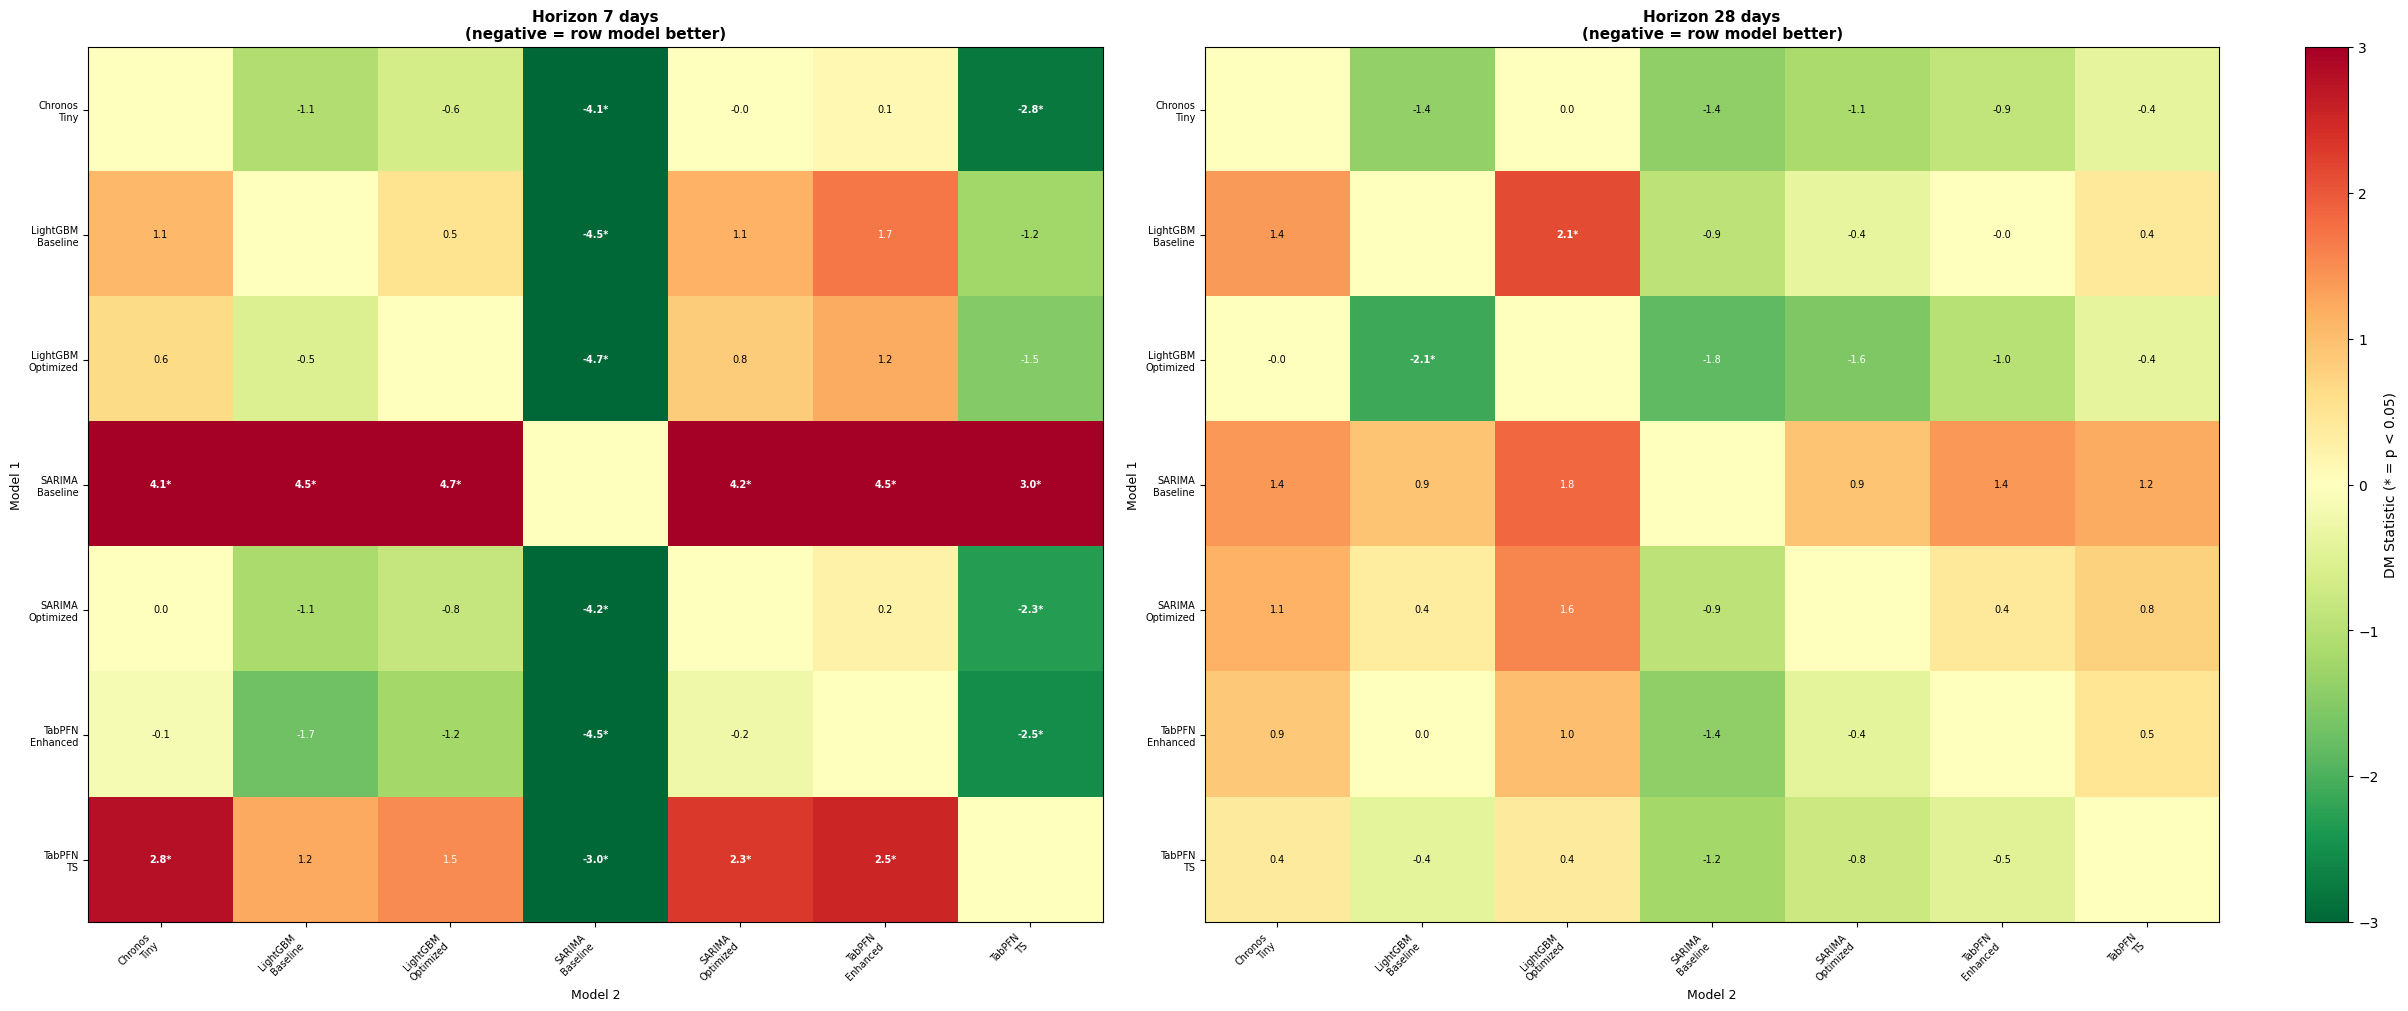

In [14]:
# Create DM matrix heatmap for each horizon
n_horizons = len(horizons)

# Define model colors for consistency with report (7 models)
model_colors = {
    'Chronos_Tiny': '#1f77b4',           # Blue
    'TabPFN_TS': '#ff7f0e',              # Orange
    'TabPFN_Enhanced': '#ff9800',        # Light orange
    'SARIMA_Baseline': '#e57373',        # Light red
    'SARIMA_Optimized': '#d32f2f',       # Dark red
    'LightGBM_Baseline': '#81c784',      # Light green
    'LightGBM_Optimized': '#388e3c'      # Dark green
}

# Determine subplot layout based on number of horizons
if n_horizons == 1:
    fig, axes = plt.subplots(1, 1, figsize=(12, 10), constrained_layout=True)
    axes = [axes]
elif n_horizons == 2:
    fig, axes = plt.subplots(1, 2, figsize=(24, 10), constrained_layout=True)
elif n_horizons == 3:
    fig, axes = plt.subplots(1, 3, figsize=(30, 10), constrained_layout=True)
else:  # 4 horizons
    fig, axes = plt.subplots(2, 2, figsize=(20, 18), constrained_layout=True)
    axes = axes.flatten()

for idx, horizon in enumerate(horizons):
    ax = axes[idx]

    # Create matrix
    n_models = len(models)
    dm_matrix = np.zeros((n_models, n_models))
    sig_matrix = np.zeros((n_models, n_models))

    for i, model1 in enumerate(models):
        for j, model2 in enumerate(models):
            if i == j:
                dm_matrix[i, j] = 0
                continue

            # Find DM test result
            result = dm_df[
                (dm_df['horizon'] == horizon) &
                ((dm_df['model1'] == model1) & (dm_df['model2'] == model2) |
                 (dm_df['model1'] == model2) & (dm_df['model2'] == model1))
            ]

            if len(result) > 0:
                row = result.iloc[0]
                # Store DM statistic (negative means model1 better)
                if row['model1'] == model1:
                    dm_matrix[i, j] = row['dm_statistic']
                else:
                    dm_matrix[i, j] = -row['dm_statistic']

                if row['p_value'] < 0.05:
                    sig_matrix[i, j] = 1

    # Plot heatmap
    im = ax.imshow(dm_matrix, cmap='RdYlGn_r', aspect='auto', vmin=-3, vmax=3)

    # Add text annotations (smaller font for 7x7 matrix)
    for i in range(n_models):
        for j in range(n_models):
            if i != j:
                text = f"{dm_matrix[i, j]:.1f}"
                if sig_matrix[i, j]:
                    text += "*"
                ax.text(j, i, text, ha='center', va='center',
                        color='white' if abs(dm_matrix[i, j]) > 1.5 else 'black',
                        fontsize=7, weight='bold' if sig_matrix[i, j] else 'normal')

    ax.set_xticks(range(n_models))
    ax.set_yticks(range(n_models))

    # Format model labels for display (more compact for 7 models)
    model_labels = []
    for m in models:
        if m == 'SARIMA_Baseline':
            model_labels.append('SARIMA\nBaseline')
        elif m == 'SARIMA_Optimized':
            model_labels.append('SARIMA\nOptimized')
        elif m == 'LightGBM_Baseline':
            model_labels.append('LightGBM\nBaseline')
        elif m == 'LightGBM_Optimized':
            model_labels.append('LightGBM\nOptimized')
        elif m == 'TabPFN_Enhanced':
            model_labels.append('TabPFN\nEnhanced')
        else:
            model_labels.append(m.replace('_', '\n'))

    ax.set_xticklabels(model_labels, rotation=45, ha='right', fontsize=7)
    ax.set_yticklabels(model_labels, fontsize=7)
    ax.set_title(f'Horizon {horizon} days\n(negative = row model better)', fontsize=11, weight='bold')
    ax.set_xlabel('Model 2', fontsize=9)
    ax.set_ylabel('Model 1', fontsize=9)

# Add colorbar to the right side of the figure
fig.colorbar(im, ax=axes, label='DM Statistic (* = p < 0.05)',
             orientation='vertical', fraction=0.046, pad=0.04)

plt.savefig(figures_dir / 'dm_matrix.png', dpi=150, bbox_inches='tight')
print(f"✅ Saved dm_matrix.png")
plt.show()

## Summary Statistics

In [15]:
# Overall rankings (average rank across horizons)
print("\n" + "=" * 60)
print("OVERALL RANKINGS (Average Rank Across Horizons)")
print("=" * 60)

for metric in ['MAPE', 'MASE', 'CRPS']:
    print(f"\n{metric}:")
    ranks = metrics_df.groupby('model')[metric].mean().sort_values()
    for rank, (model, value) in enumerate(ranks.items(), 1):
        print(f"  {rank}. {model}: {value:.2f}")


OVERALL RANKINGS (Average Rank Across Horizons)

MAPE:
  1. TabPFN_Enhanced: 28.99
  2. Chronos_Tiny: 31.55
  3. LightGBM_Optimized: 39.75
  4. TabPFN_TS: 39.91
  5. LightGBM_Baseline: 43.74
  6. SARIMA_Optimized: 50.48
  7. SARIMA_Baseline: 67.56

MASE:
  1. Chronos_Tiny: 0.49
  2. SARIMA_Optimized: 0.52
  3. TabPFN_Enhanced: 0.52
  4. LightGBM_Optimized: 0.55
  5. TabPFN_TS: 0.62
  6. LightGBM_Baseline: 0.64
  7. SARIMA_Baseline: 1.09

CRPS:
  1. Chronos_Tiny: 2.65
  2. LightGBM_Optimized: 2.76
  3. TabPFN_Enhanced: 3.04
  4. SARIMA_Optimized: 3.19
  5. LightGBM_Baseline: 3.22
  6. TabPFN_TS: 3.37
  7. SARIMA_Baseline: 5.27


In [16]:
# Best model by horizon and metric
print("\n" + "=" * 60)
print("BEST MODEL BY HORIZON AND METRIC")
print("=" * 60)

for horizon in horizons:
    print(f"\nHorizon {horizon} days:")
    subset = metrics_df[metrics_df['horizon'] == horizon].copy()

    for metric in ['MAPE', 'MASE', 'CRPS']:
        best_row = subset.loc[subset[metric].idxmin()]
        print(f"  {metric}: {best_row['model']} ({best_row[metric]:.2f})")

    # Coverage closest to 80%
    subset['coverage_diff'] = np.abs(subset['Coverage_80'] - 80)
    best_coverage = subset.loc[subset['coverage_diff'].idxmin()]
    print(f"  Coverage: {best_coverage['model']} ({best_coverage['Coverage_80']:.1f}%)")


BEST MODEL BY HORIZON AND METRIC

Horizon 7 days:
  MAPE: TabPFN_Enhanced (14.14)
  MASE: TabPFN_Enhanced (0.18)
  CRPS: TabPFN_Enhanced (1.16)
  Coverage: TabPFN_Enhanced (79.2%)

Horizon 28 days:
  MAPE: TabPFN_Enhanced (43.84)
  MASE: Chronos_Tiny (0.77)
  CRPS: LightGBM_Optimized (4.11)
  Coverage: SARIMA_Optimized (82.6%)


## Evaluation Complete

This notebook evaluates 7 models:
- **Foundation Models:** Chronos-Tiny (zero-shot)
- **TabPFN Variants:** TabPFN-TS (baseline univariate), TabPFN-Enhanced (+ calendar features)
- **SARIMA Variants:** SARIMA_Baseline (fixed order 1,0,1), SARIMA_Optimized (AutoARIMA)
- **LightGBM Variants:** LightGBM_Baseline (default hyperparameters), LightGBM_Optimized (Optuna tuning)

Key outputs:
- `results/summary.csv`: All metrics by model and horizon (7 models × 2 horizons × 5 metrics)
- `results/dm_tests.csv`: Diebold-Mariano statistical test results (all pairs)
- `results/figures/dm_matrix.png`: Statistical significance heatmap (7×7 for each horizon)

**Key Findings:**
1. **Optimization impact:** Direct comparison of baseline vs optimized shows quantifiable improvement
2. **Feature engineering impact:** TabPFN_Enhanced demonstrates the value of calendar features
3. **Model-task alignment:** Foundation models need appropriate inputs (features vs zero-shot)
4. **Statistical significance:** DM tests reveal which differences are meaningful

**Analysis:**
- **Baseline vs Optimized:** summary.csv now includes both versions for direct comparison
- **Foundation models:** Chronos performs well zero-shot; TabPFN benefits from features
- **Statistical tests:** DM matrix shows pairwise comparisons with significance markers

Next: Run [04_report.ipynb](04_report.ipynb) for visualizations